In [20]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16
from keras import models, layers
import matplotlib.pyplot as plt
from keras import optimizers
import numpy as np
import os


# Feature extraction

In [21]:
# Initializing convulation base
conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

In [22]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

The convulation base above is used for feature extraction that we will use as input for our dense layers
    The feature extraction can be done in two ways
        1). By recording conv-base output into numpy array. Its fast and cheap without data augumentation
        2). By extending the model by adding dense layers on top. Allow data augumentation. Very expensive

# Feature extraction without data augumentation

In [23]:
# Selecting dataset directories
base_dir ='/Users/Tajr/Desktop/Data/RadonPlus/RadonTechnology/Dev/Deep Learning/Datasets/CatDog/SmallDataset'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')
validation_dir = os.path.join(base_dir, 'validation')
print('successful')

successful


In [24]:
# Extract image data as numpy array
datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20
print('successful')

successful


In [25]:
# Features are extracted by calling predict method of a convulation base
def extract_feature(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(directory, target_size=(150, 150), batch_size=batch_size, class_mode='binary')
    
    i = 0
    for inputs_batch, label_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i +1) * batch_size] = features_batch
        labels[i* batch_size : (i + 1) * batch_size] = label_batch
        i += 1
        
#         Break is used because generators yield data indefinitely in a loop. Break is must after every image has been seen once
        if i *batch_size >= sample_count:
            break
    
    return features, labels

In [26]:
train_features, train_labels = extract_feature(train_dir, 2000)
test_features, test_labels = extract_feature(test_dir, 1000)
validation_features, validation_labels = extract_feature(validation_dir, 1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [27]:
train_features.shape

(2000, 4, 4, 512)

In [28]:

# Flattening the features (samples, x * y* z) from  convulation base before feeding them into densely connected classifier
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
test_features =np.reshape(test_features, (1000, 4 * 4 * 512))
validation_features =np.reshape(validation_features, (1000, 4 * 4 * 512))

In [29]:
train_features.shape

(2000, 8192)

# Dense classifier
   Drop out is used for regularization

In [30]:
# Model definition
model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

# Model compilation
model.compile(optimizer=optimizers.RMSprop(lr=2e-5),loss='binary_crossentropy', metrics=['acc'])

# Training a model
history = model.fit(test_features, test_labels, epochs=30, batch_size=20,validation_data=(validation_features, validation_labels))
        

Train on 1000 samples, validate on 1000 samples
Epoch 1/30
1000/1000 [==============================] - 1s 1ms/step - loss: 0.6916 - acc: 0.6070 - val_loss: 0.5118 - val_acc: 0.7990
Epoch 2/30
1000/1000 [==============================] - 1s 904us/step - loss: 0.5272 - acc: 0.7410 - val_loss: 0.4355 - val_acc: 0.8320
Epoch 3/30
1000/1000 [==============================] - 1s 910us/step - loss: 0.4401 - acc: 0.7970 - val_loss: 0.3866 - val_acc: 0.8670
Epoch 4/30
1000/1000 [==============================] - 1s 934us/step - loss: 0.4110 - acc: 0.8220 - val_loss: 0.3579 - val_acc: 0.8770
Epoch 5/30
1000/1000 [==============================] - 1s 1ms/step - loss: 0.3609 - acc: 0.8420 - val_loss: 0.3392 - val_acc: 0.8720
Epoch 6/30
1000/1000 [==============================] - 1s 926us/step - loss: 0.3326 - acc: 0.8570 - val_loss: 0.3241 - val_acc: 0.8800
Epoch 7/30
1000/1000 [==============================] - 1s 911us/step - loss: 0.3108 - acc: 0.8720 - val_loss: 0.3099 - val_acc: 0.8920
Epoc

In [31]:
# Plotting the results
history_dict = history.history
history_dict.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

In [36]:
# Data
accuracy = history_dict['acc']
val_accuracy = history_dict['val_acc']

loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1,( len(accuracy) + 1))

<function matplotlib.pyplot.show(*args, **kw)>

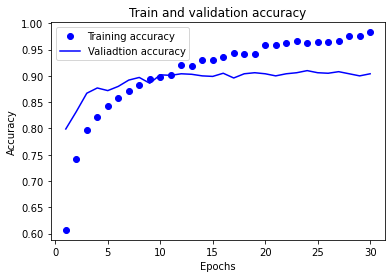

In [37]:
# Train accuracy Vs Validation accuracy
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Valiadtion accuracy')
plt.title('Train and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

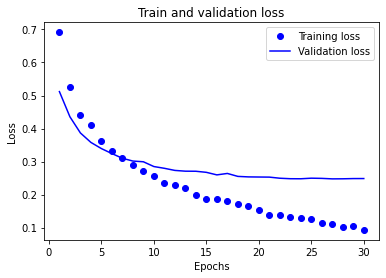

In [38]:
plt.clf()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Train and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show

# Conclusion

Via This technique we have been able to acomplish a validation accuracy of 90%

In [39]:
result = model.evaluate(test_features, test_labels)

1000/1000 [==============================] - 0s 154us/step


In [40]:
result

[0.07799012631177903, 0.9909999966621399]